# Data cleaning from new Database

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from urllib.request import urlopen
from json import load
from collections import Counter
from tqdm import tqdm

sns.set_style('white')
sns.set_context('notebook')

# 1. Read in the SQL Database

In [3]:
conn = sqlite3.connect('./Data/knwlg_blf.db')
dat = pd.read_sql("SELECT * FROM trials JOIN subjects ON trials.prolific_id=subjects.prolific_id JOIN autism_scores ON autism_scores.prolific_id=subjects.prolific_id JOIN demographics ON demographics.prolific_id=subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%'  ", con=conn)
dat = dat[['trial_num', 'correct', 'trial_type', 'scenario', 'belief_type', 'ascription_type', 'correct_answer', 'target_onset', 'response_onset','keypress_time', 'response_key', 'ip_addy', 'prolific_id','participation_date', 'GMT_timestamp', 'email', 'recaptcha_complete', 'completion_code', 'completion_time', 'feedback', 'AQ_rating_1', 'AQ_rating_2', 'AQ_rating_3', 'AQ_rating_4', 'AQ_rating_5', 'AQ_rating_6', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_9', 'AQ_rating_10', 'age', 'gender', 'ethnicity', 'education', 'diag', 'autism_exp']].reset_index(drop=True)

Index(['id', 'trial_num', 'correct', 'trial_type', 'scenario', 'belief_type',
       'ascription_type', 'correct_answer', 'target_onset', 'response_onset',
       'keypress_time', 'response_key', 'ip_addy', 'prolific_id',
       'prolific_id', 'session_id', 'participation_date', 'browser',
       'browser_version', 'screen_width', 'screen_height', 'operating_sys',
       'operating_sys_lang', 'GMT_timestamp', 'email', 'recaptcha_complete',
       'block1_complete', 'block2_complete', 'block3_complete',
       'completion_code', 'completion_time', 'feedback', 'id', 'AQ_rating_1',
       'AQ_rating_2', 'AQ_rating_3', 'AQ_rating_4', 'AQ_rating_5',
       'AQ_rating_6', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_9',
       'AQ_rating_10', 'prolific_id', 'id', 'age', 'gender', 'ethnicity',
       'education', 'diag', 'autism_exp', 'prolific_id'],
      dtype='object')

In [2]:
conn = sqlite3.connect('./Data/knwlg_blf.db')
dat = pd.read_sql("SELECT * FROM trials JOIN subjects ON trials.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%'", con=conn)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dat = dat.loc[dat.trial_type == 'test'].reset_index(drop=True)
dat['email'] = dat.email.str.lower().str.strip()
# Remove a weird subjects. Who might be in db twice
dat = dat.loc[~dat.target_onset.isnull()]

dat['response_key'] = dat.response_key.apply(eval)
dat['keypress_time'] = [eval(x) for x in dat.keypress_time]
dat = dat[[xx == list for xx in [type(x) for x in dat.response_key]]].reset_index(drop=True) # make sure responses are saved as a list.

# 2. Recruitment: How many people received an email?

In [3]:
access = pd.read_sql("SELECT * FROM access_code", con=conn)
print(f'{len(access.email.unique())} different people filled out the screener. \n {sum(access.used)} ({sum(access.used)/len(access.email.unique()) * 100:.2f} %) of those started the experiment. \n Of those who started, {len(dat.prolific_id.unique())} ({len(dat.prolific_id.unique())/sum(access.used)* 100:3.3} %) finished it', )


1317 different people filled out the screener. 
 684 (51.94 %) of those started the experiment. 
 Of those who started, 622 (90.9 %) finished it


## Convert SQL strings to python datetime object and compute timedeltas

In [4]:
def convert_time(x):
    if type(x) == str:
        return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

dat[['response_onset','target_onset','participation_date','completion_time']] = dat[['response_onset','target_onset','participation_date','completion_time']].applymap(convert_time)

dat['rt'] = dat.apply(lambda row: row['response_onset'] - row['target_onset'], axis=1)
dat['rt_ms'] = dat.apply(lambda row: int(round(row['rt'].total_seconds() * 1e3)), axis=1)

## Time to Complete

<ipython-input-5-c95fb9b4b458>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = sns.histplot(dat.groupby('prolific_id').mean()['total_duration_mins'])


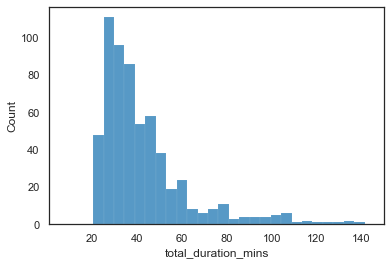

In [5]:
dat['study_duration'] = dat.apply(lambda row: row['completion_time'] - row['participation_date'], axis=1)
dat['total_duration_mins'] = dat.apply(lambda row: (row['completion_time'] - row['participation_date']).total_seconds()/60, axis=1)
dat = dat.sort_values('participation_date', ascending=False).reset_index(drop=True)
g = sns.histplot(dat.groupby('prolific_id').mean()['total_duration_mins'])
g.set_xlim(1, 150);

# 3. Exclusions

Sometimes, the 5-second timer was reached before the data was sent to the sever. This could happen if someone has a slower internet. Results in '999' response after subject's initial key press. The following two cells correct this.

In [6]:
# If subjects hit more than one key, use only the last one
dat['full_response'] = dat['response_key']
dat['response_key'] = [resp[-1].lower() for resp in dat.response_key]
dat['corrected_resp'] = dat.response_key
dat['corrected_rt'] = dat.rt_ms


In [7]:
for i, trl in dat[dat.apply(lambda row: len(row['full_response']) > 1, axis=1)].iterrows(): # iterate through rows where >1  response was made
    keys_pressed = list(Counter(trl.full_response).keys()) # list the unique keys, in the temporal order they were pressed. fjf -> fj
    if '999' in keys_pressed: # if the timer hit 5 seconds
        if keys_pressed.index('999') == 0: # and there were no other keys pressed before then
            intended_answer = '999' # their answer is recorded as 999
        else : # if there were other keys pressed before the 5-second timer (but the 5 seconds  was still reached because of internet transfer)
            intended_answer = keys_pressed[:keys_pressed.index('999')][-1] # the last key pressed before the 999 was the intended response
    else:     # If there is no timeout, take the first instance of the last key pressed.
        kp = [x for x in keys_pressed if x =='f'or x== 'j']
        if len(kp) > 0:
            intended_answer = kp[-1]
        else:
            intended_answer = keys_pressed[-1]

    onset = trl.keypress_time[trl.full_response.index(intended_answer)] #onset of the first instance of the last key pressed.
    rt = int((onset - trl.target_onset).total_seconds() * 1e3)  # compute the RT for that key press
    dat.loc[dat.id == trl.id, ['corrected_resp', 'corrected_rt']] = intended_answer, rt


### Note where subjects entered invalid responses

In [8]:
accepted_answers = ['f', 'j', '999']
dat['accepted_answer'] = None
for i, response in enumerate(dat.response_key):
    if sum([key.lower() in accepted_answers for key in response]) >= 1:  # == len(response):
        dat.loc[i, 'accepted_answer'] = True
    else:
        dat.loc[i, 'accepted_answer'] = False

print(f"{len(dat.loc[dat.accepted_answer == False].prolific_id.unique())} participants responded at least one trial with invalid keys. \n")


506 participants responded at least one trial with invalid keys. 



### Note trials where subjects timed-out after the 5-seconds

In [9]:
dat['timeout'] = False
dat.loc[dat.corrected_resp == '999', 'timeout'] = True
print(f"{len(dat.loc[dat.timeout == True].prolific_id.unique())} participants timed out during at least one trial. \n")

325 participants timed out during at least one trial. 



# compute accuracy

In [10]:
#  correct answers
dat.loc[dat.belief_type == 'TB', 'correct_answer'] = 'j'
dat.loc[dat.belief_type != 'TB', 'correct_answer'] = 'f'
# update correct column based on new answer key
dat['correct'] = dat.apply(lambda row: row['corrected_resp'] == row['correct_answer'], axis=1)

# timeouts are considered incorrect
dat.loc[dat.timeout == True, 'correct'] = False

In [11]:
threshold = .67
dat[['accurate', 'too_fast', 'too_slow', 'in_sample']] = False

for subj in tqdm(dat.prolific_id.unique()):
    sdat = dat.loc[dat.prolific_id == subj]
    if len(sdat) != 12:
        print('ohshit')
        break
    if sdat.correct.mean() >= threshold:
        dat.loc[dat.prolific_id == subj, 'accurate'] = True
    if sdat.corrected_rt.mean() < 1000:
        dat.loc[dat.prolific_id == subj, 'too_fast'] = True
    if sdat.corrected_rt.mean() > 4000:
        dat.loc[dat.prolific_id == subj, 'too_slow'] = True


dat.loc[(dat.accurate == True) & (dat.too_fast == False) & (dat.too_slow == False), 'in_sample'] = True
print(f'before exclusions, {len(dat.prolific_id.unique())} subjects had completed the task. ')
print(f'After excluding for accuracy above {threshold},  {len(dat.loc[dat.accurate == True].prolific_id.unique())} subjects ({(len(dat.loc[dat.accurate == True].prolific_id.unique())/len(dat.prolific_id.unique())) * 100 :.3} %)remain in the sample')
print(f'{len(dat.loc[(dat.accurate == True) & (dat.too_slow == True)].prolific_id.unique())} additional subjects excluded for mean RT < 1000ms')
print(f'{len(dat.loc[(dat.accurate == True) & (dat.too_fast == True)].prolific_id.unique())} additional subjects excluded for mean RT > 4000ms')
print(f'After exclusions,  {len(dat.loc[dat.in_sample == True].prolific_id.unique())} subjects remain in the sample')


100%|██████████| 622/622 [00:02<00:00, 218.75it/s]


before exclusions, 622 subjects had completed the task. 
After excluding for accuracy above 0.67,  237 subjects (38.1 %)remain in the sample
0 additional subjects excluded for mean RT < 1000ms
0 additional subjects excluded for mean RT > 4000ms
After exclusions,  237 subjects remain in the sample


In [ ]:
import numpy as np

dat.groupby('prolific_id').correct.mean().hist(bins=12);
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.vlines(.67, ymin=0, ymax=100, colors='red')
#plt.savefig('./Figures/aut_raw_acc.png', dpi=300.0)

In [ ]:
dat.loc[dat.accurate== True].groupby('prolific_id').corrected_rt.mean().hist(bins=30)
plt.xlabel('Subject Mean Response Time (ms)')
plt.ylabel('Count')
plt.xticks(np.arange(0, 6000, step=1000))
plt.vlines(1000, ymin=0, ymax=25, colors='red')
plt.vlines(4000, ymin=0, ymax=25, colors='red')

#plt.savefig('./Figures/aut_avgRT.png', dpi=300.0)

In [71]:
# Remove trials
dat.loc[(dat.corrected_rt < 1000) | (dat.corrected_rt > 4500), 'in_sample'] = False


In [ ]:
dat[["mailfence" in x for x in dat.email]].loc[dat.in_sample == True].prolific_id.unique()

In [72]:
dat = dat[["mailfence" not in x for x in dat.email]]

In [ ]:
len(dat.loc[dat.in_sample== True].prolific_id.unique())

# 4. Accuracy

In [ ]:
dat.loc[dat.in_sample == True].groupby(['prolific_id']).correct.mean().hist(bins=10)


In [40]:
acc_dat = full.groupby(['prolific_id', 'group', 'ascription_type', 'belief_type']).correct.mean()
acc_dat = acc_dat.reset_index()
acc_dat

,prolific_id,group,ascription_type,belief_type,correct
0,02OPMpVlcM6K26G6,autism,Knows,False Info,0.5
1,02OPMpVlcM6K26G6,autism,Knows,Ignorance,1.0
2,02OPMpVlcM6K26G6,autism,Knows,True Info,1.0
3,02OPMpVlcM6K26G6,autism,Thinks,False Info,0.5
4,02OPMpVlcM6K26G6,autism,Thinks,Ignorance,1.0
...,...,...,...,...,...
3815,zaQE00Dsl0GKtokF,autism,Knows,Ignorance,1.0
3816,zaQE00Dsl0GKtokF,autism,Knows,True Info,0.0
3817,zaQE00Dsl0GKtokF,autism,Thinks,False Info,1.0
3818,zaQE00Dsl0GKtokF,autism,Thinks,Ignorance,1.0


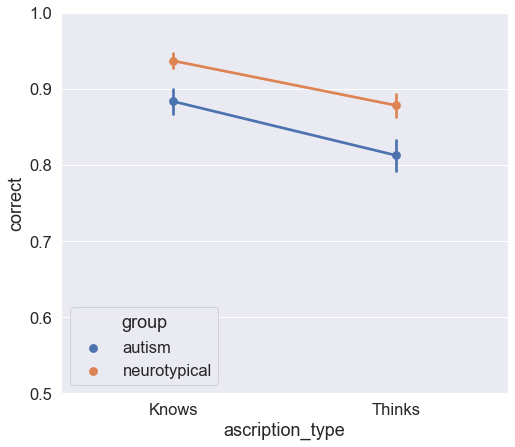

In [47]:
fig, ax = plt.subplots(figsize=(8,7))
sns.pointplot(hue='group', y='correct', x='ascription_type', data=acc_dat, ax=ax);
plt.ylim([.5, 1])
plt.savefig('./Figures/acc_groupxascipt.png', dpi=300)

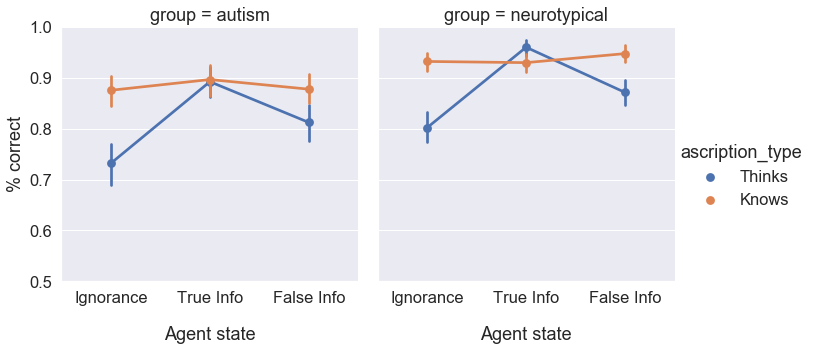

In [52]:
sns.set(font_scale=1.5)
g = sns.catplot(hue='ascription_type', x='belief_type', order=['Ignorance', 'True Info', 'False Info'], y='correct', hue_order=['Thinks', 'Knows'], data=acc_dat, col='group', kind='point');
g.set(ylim=(.5, 1));

for aa in [0, 1]:
    g.axes[0][aa].yaxis.set_label_text("% correct")
    g.axes[0][aa].xaxis.set_label_text("Agent state")
    g.axes[0][aa].xaxis.labelpad = 20


plt.savefig('./Figures/groupxagentxascrip.png')

## Compare with controls

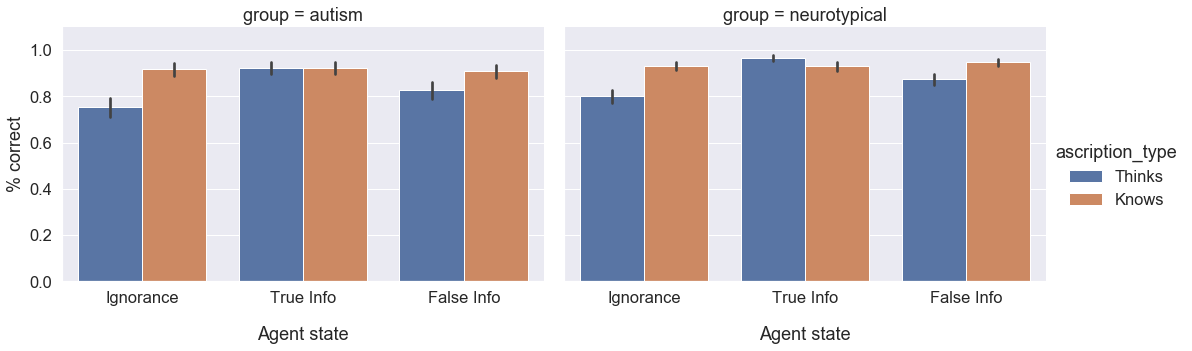

In [77]:
dat['group'] = 'autism'
cntrls = pd.read_csv('./Data/controls.csv', index_col=0, header=0)
cntrls['group'] = 'neurotypical'
cntrls['corrected_rt'] = cntrls.rt_ms

full = pd.concat([dat.loc[dat.in_sample == True,  ['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'correct', 'corrected_rt', 'group']],
                  cntrls[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'correct', 'corrected_rt', 'group']]], ignore_index=True)

for old, new in {'IG':'Ignorance', 'TB':'True Info', 'FB':'False Info'}.items():
    full.belief_type.replace(old, new, inplace=True)


sns.set(font_scale=1.5)
g = sns.catplot(x='belief_type', order=['Ignorance', 'True Info', 'False Info'], y='correct', hue='ascription_type', hue_order=['Thinks', 'Knows'], col='group', kind='bar', data=full, aspect=1.5);
g.set(ylim=(0, 1.1));

for aa in [0, 1]:
    g.axes[0][aa].yaxis.set_label_text("% correct")
    g.axes[0][aa].xaxis.set_label_text("Agent state")
    g.axes[0][aa].xaxis.labelpad = 20


plt.savefig('./Figures/acc_group.png')

In [ ]:
dat.loc[dat.in_sample == True].groupby(['scenario','belief_type', 'ascription_type']).correct.mean()

# 5. Reaction Times

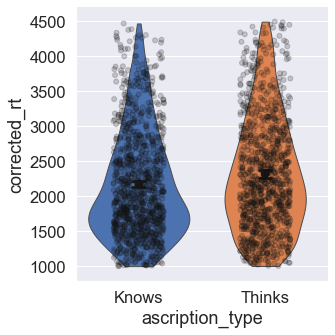

In [68]:
#dat['ascription_type'] = dat.ascription_type.astype(str)
sns.catplot(x='ascription_type', y='corrected_rt', kind='violin', cut=0, bw=.25, linewidth=1, saturation=1, inner=None, aspect=1, data=dat.loc[(dat.in_sample==True) & (dat.correct ==True)])
sns.stripplot(x='ascription_type', order=['Knows', 'Thinks'], y='corrected_rt', data=dat.loc[(dat.in_sample==True) & (dat.correct ==True)], color='k', dodge=True, jitter=.2, linewidth=1, alpha=.2)
sns.pointplot(x='ascription_type', order=['Knows', 'Thinks'], y='corrected_rt', data=dat.loc[(dat.in_sample ==True) & (dat.correct ==True)], join=False, dodge=.4, capsize=.1, color='k',)


In [ ]:
def plot_var(x_var='belief_type', x_order=['IG', 'TB', 'FB'], hue_var='ascription_type', hue_order=['Thinks', 'Knows']):
    fig, ax = plt.subplots(figsize=(15, 12))
    g = sns.violinplot(x=x_var, order=x_order, y='corrected_rt', hue=hue_var, hue_order=hue_order, data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True) & (dat.in_sample == True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
    g = sns.stripplot(x=x_var, order=x_order, y='corrected_rt', hue=hue_var, hue_order=hue_order, data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
    g= sns.pointplot(x=x_var, order=x_order, y='corrected_rt', hue=hue_var, hue_order=hue_order, data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

    ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
    g.yaxis.set_label_text("response time (ms)")
    g.xaxis.set_label_text(x_var)
    ax.xaxis.labelpad = 20


In [ ]:
plot_var(x_var='scenario', x_order=range(1,13))

In [ ]:
import json
json_fp = '../KnowledgeBelief/static/stim_data/KB_stim.json'
with open(json_fp, 'r') as j:
    stim = json.loads(j.read())

stim['test']['6']['belief_manip']['IG']

In [ ]:
stim['test']['6']['ascription']['Knows']


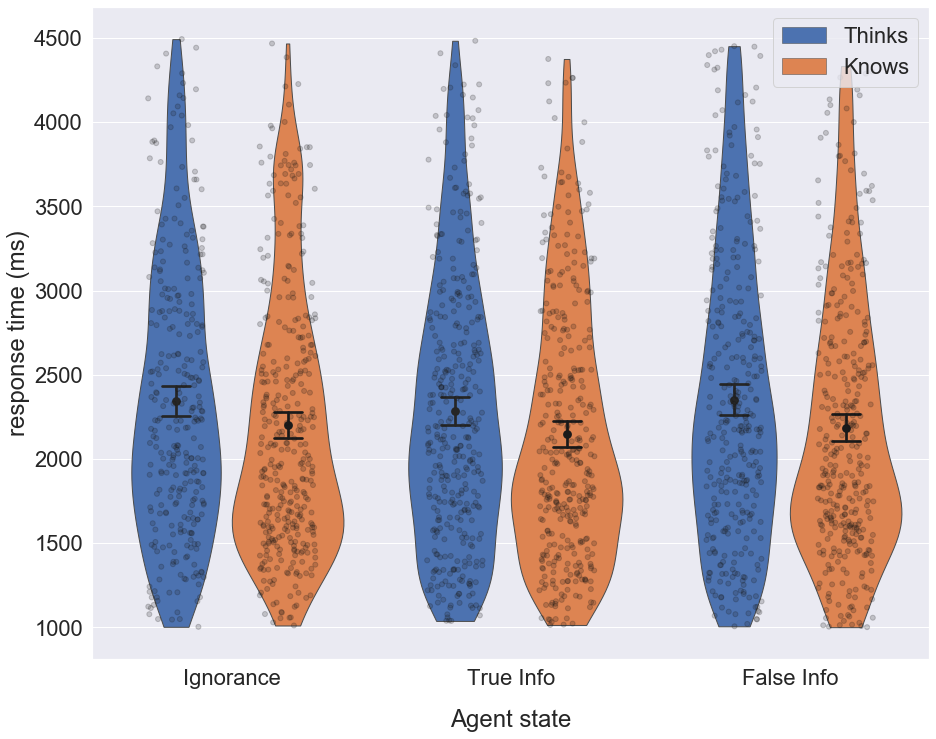

In [81]:
#sns.set_context('notebook', font_scale=2)
for old, new in {'IG':'Ignorance', 'TB':'True Info', 'FB':'False Info'}.items():
    dat.belief_type.replace(old, new, inplace=True)

fig, ax = plt.subplots(figsize=(15, 12))
g = sns.violinplot(x='belief_type', order=['Ignorance', 'True Info', 'False Info'],y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True) & (dat.in_sample == True)], cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)
g = sns.stripplot(x='belief_type', order=['Ignorance', 'True Info', 'False Info'], y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], color='k', dodge=True, ax=ax, jitter=.2, linewidth=1, alpha=.2)
g= sns.pointplot(x='belief_type',order=['Ignorance', 'True Info', 'False Info'], y='corrected_rt', hue='ascription_type', hue_order=['Thinks', 'Knows'], data=dat.loc[(dat.trial_type=='test') & (dat.correct ==True)& (dat.in_sample == True)], join=False, dodge=.4, capsize=.1, ax=ax, color='k',)

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
g.yaxis.set_label_text("response time (ms)")
g.xaxis.set_label_text("Agent state")
ax.xaxis.labelpad = 20


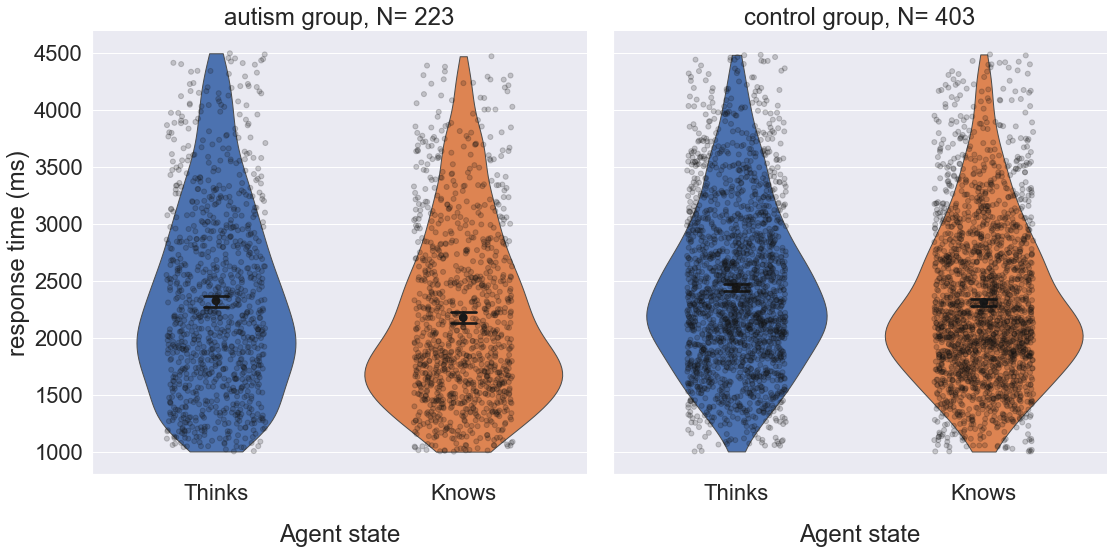

In [86]:
sns.set(font_scale=2)
g = sns.catplot(x='ascription_type', y='corrected_rt', order=['Thinks', 'Knows'], kind='violin', cut=0,col='group', data=full.loc[(full.correct == True)], inner=None, bw=.25, linewidth=1, saturation=1, height=8, aspect=1);

sns.stripplot(x='ascription_type', y='corrected_rt', order=['Thinks', 'Knows'], data=full.loc[(full.correct ==True) & (full.group == 'autism')], color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=g.axes[0][0]);

sns.stripplot(x='ascription_type', y='corrected_rt', order=['Thinks', 'Knows'], data=full.loc[(full.correct ==True) & (full.group == 'neurotypical')], color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=g.axes[0][1]);

sns.pointplot(x='ascription_type', y='corrected_rt', order=['Thinks', 'Knows'], data=full.loc[(full.correct == True) & (full.group == 'autism')], join=False, dodge=.4, capsize=.1, ax=g.axes[0][0], color='k',);

sns.pointplot(x='ascription_type', y='corrected_rt', order=['Thinks', 'Knows'], data=full.loc[(full.correct == True) & (full.group == 'neurotypical')], join=False, dodge=.4, capsize=.1, ax=g.axes[0][1], color='k',);


#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
for aa in [0, 1]:
    g.axes[0][aa].yaxis.set_label_text("response time (ms)")
    g.axes[0][aa].xaxis.set_label_text("Agent state")
    g.axes[0][aa].xaxis.labelpad = 20
    #g.axes[0][aa].legend_.remove()

g.axes[0][0].title.set_text(f'autism group, N= {len(full.loc[full.group=="autism"].prolific_id.unique())}')
g.axes[0][1].title.set_text(f'control group, N= {len(full.loc[full.group=="neurotypical"].prolific_id.unique())}')

plt.savefig('./Figures/groupcomp_ascrip.png')

In [80]:
dat.loc[dat.email== 'oguard42@gmail.com']

,id,trial_num,correct,trial_type,scenario,belief_type,ascription_type,correct_answer,target_onset,response_onset,...,full_response,corrected_resp,corrected_rt,accepted_answer,timeout,accurate,too_fast,too_slow,in_sample,group
3972,7330,10,False,test,8,FB,Thinks,f,2022-09-28 12:33:42.315,2022-09-28 12:33:44.768,...,[j],j,2453,True,False,False,False,False,False,autism
3973,7322,2,True,test,11,TB,Thinks,j,2022-09-28 12:29:38.272,2022-09-28 12:29:41.230,...,[j],j,2958,True,False,False,False,False,False,autism
3974,7323,3,True,test,5,IG,Knows,f,2022-09-28 12:30:06.140,2022-09-28 12:30:08.265,...,[f],f,2125,True,False,False,False,False,False,autism
3975,7324,4,True,test,4,IG,Knows,f,2022-09-28 12:30:32.847,2022-09-28 12:30:37.850,...,"[f, 999]",f,2133,False,False,False,False,False,False,autism
3976,7325,5,False,test,3,FB,Knows,f,2022-09-28 12:31:07.108,2022-09-28 12:31:12.113,...,[999],999,5005,False,True,False,False,False,False,autism
3977,7328,8,False,test,6,TB,Knows,j,2022-09-28 12:32:43.019,2022-09-28 12:32:49.250,...,"[999, f, j]",999,4982,True,True,False,False,False,False,autism
3978,7331,11,False,test,12,TB,Knows,j,2022-09-28 12:34:13.721,2022-09-28 12:34:17.075,...,[f],f,3354,True,False,False,False,False,False,autism
3979,7333,13,True,test,7,IG,Thinks,f,2022-09-28 12:35:48.002,2022-09-28 12:35:53.001,...,"[f, 999]",f,4229,False,False,False,False,False,False,autism
3980,7339,19,True,test,10,TB,Thinks,j,2022-09-28 12:38:43.217,2022-09-28 12:38:46.387,...,[j],j,3170,True,False,False,False,False,False,autism
3981,7342,22,False,test,9,IG,Thinks,f,2022-09-28 12:41:09.080,2022-09-28 12:41:11.181,...,[j],j,2101,True,False,False,False,False,False,autism


 # 3. Location

In [ ]:

dat[['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']] = None
baddies = []
for subj in tqdm(dat.prolific_id.unique()):
    addr = dat.loc[dat.prolific_id == subj, 'ip_addy'].values[0]
    url = 'https://ipinfo.io/' + addr + '/json'
    res = urlopen(url)
    #response from url(if res==None then check connection)
    data = load(res)
    try:
        dat.loc[dat.prolific_id == subj, ['city', 'region', 'country', 'loc', 'org', 'postal', 'timezone', 'email', 'participation_date', 'study_duration']] = [data['city'], data['region'], data['country'], data['loc'], data['org'], data['postal'], data['timezone'], dat.loc[dat.prolific_id == subj, 'email'].values[0], dat.loc[dat.prolific_id == subj, 'participation_date'].values[0], dat.loc[dat.prolific_id == subj, 'study_duration'].values[0]]
    except:
        baddies.append(subj)
        print(f'issue with id: {subj}')

In [ ]:
xx = dat.groupby(['prolific_id','participation_date', 'email', 'ip_addy','study_duration', 'city', 'region', 'country', 'loc', 'org', 'postal', 'timezone']).correct.mean()#.sort_values('correct')
yy = xx.reset_index().sort_values('correct', axis=0)
#yy[[yy.correct >]]
yy.loc[yy.correct>=threshold]#.prolific_id.unique()#.email

In [ ]:
yy.loc[yy.email == 'kenkarren440@gmail.com']

## Save info for payments

In [ ]:
dat.to_csv('./Data/asc_cohort_10_10_22.csv')

In [ ]:
em = dat.loc[dat.in_sample == True].email.unique()

#
pd.Series(em).to_csv('./Data/subs2pay_10_10_2022.csv', sep=',')

who is outside USA

In [ ]:
yy.loc[yy.prolific_id.isin(dat.loc[(dat.country != 'US') & (dat.in_sample == True)].prolific_id.unique())]

Make sure subjects doesn't enter the same response on all trials

In [ ]:
for subj in dat.prolific_id.unique():
#subj = dat.prolific_id.unique()[35]
    sdat = dat.loc[dat.prolific_id == subj]
    if len(set(sdat.corrected_resp.values)) == 1:
        print('check out subject: ', subj)

# 5. AQ-10

In [74]:
# Autistics
a_dat1 = pd.read_sql("SELECT * FROM autism_scores JOIN subjects ON autism_scores.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%'", con=conn)
a_dat1 = a_dat1.loc[:,~a_dat1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
a_dat1 = a_dat1[a_dat1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique()).values] # only use subjects in trial analysis

a_dat1['group'] =  'autism'

# controls
conn2 = sqlite3.connect('./Data/knwlg_blf_controls.db')
a_dat2 = pd.read_sql('SELECT * FROM autism_scores A JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code="548DA3BD"', con=conn2)
a_dat2 = a_dat2.loc[:,~a_dat2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
a_dat2 = a_dat2[a_dat2.prolific_id.isin(full.prolific_id.unique()).values] # only use subjects in trial analysis
a_dat2['group'] = 'neurotypical'

a_dat = pd.concat(objs=[a_dat1,a_dat2], ignore_index=True)

    ## Scoring

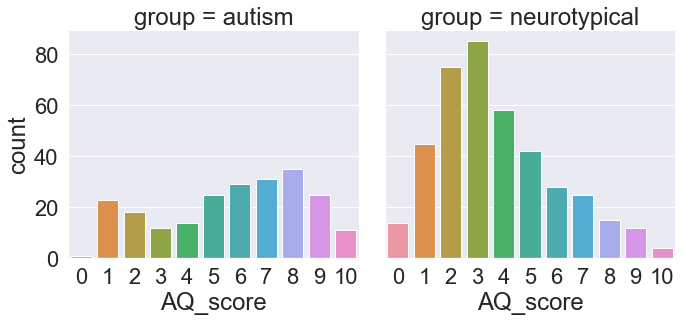

In [75]:
## Scoring
agree = ['AQ_rating_1', 'AQ_rating_7', 'AQ_rating_8', 'AQ_rating_10'] # score of 3 or 4 get a point
disagree = ['AQ_rating_2','AQ_rating_3','AQ_rating_4','AQ_rating_5','AQ_rating_6','AQ_rating_9', ] # score of 1 or 2 get a point]
a = a_dat[agree] >= 3
b = a_dat[disagree] < 3
a_dat['AQ_score'] = a.sum(axis=1) + b.sum(axis=1)
a_dat = a_dat[a_dat.prolific_id.isin(full.prolific_id.unique().tolist())]

#fg, ax = plt.subplots(figsize=(10, 8))
sns.catplot(data=a_dat, x='AQ_score', col='group', kind='count')

In [ ]:
cdat = full.loc[full.correct ==True]
for subject in tqdm(full.prolific_id.unique()):
    # calculate mean RT for belief ascription # CORRECT  TRIALS ONLY
    a_dat.loc[a_dat.prolific_id == subject, 'avg_ThinkRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Thinks')].corrected_rt.mean()
    a_dat.loc[a_dat.prolific_id == subject, 'avg_KnowRT'] = cdat.loc[(cdat.prolific_id == subject) & (cdat.ascription_type == 'Knows')].corrected_rt.mean()

a_dat['RT_diff'] = a_dat.apply(lambda row: row['avg_ThinkRT'] - row['avg_KnowRT'], axis=1)

In [ ]:
sns.set_context("notebook")
sns.lmplot(x='AQ_score', y='RT_diff',col='group', data=a_dat);
# Maybe do this for the unique items? scenario, belief, ascription

# 6. Felicity Judgements

In [76]:
f1 = pd.read_sql("SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code LIKE '%XXX%'", con=conn)
f1 = f1.loc[:,~f1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
# Remove weird subjects. Who might be in db twice
f1 = f1.loc[~f1.felicity_rating.isnull()]
f1['Infelicity Rating'] = 8 - f1.felicity_rating # 1= "Sounds very weird",  7 = "Sounds very normal"
f1 = f1[f1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique())].reset_index(drop=True)
f1['group'] = 'autism'
f1.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

f2 = pd.read_sql("SELECT * FROM felicities A INNER JOIN subjects B ON A.prolific_id = B.prolific_id WHERE B.completion_code LIKE '%548DA3BD%'", con=conn2)
f2 = f2.loc[:, ~f2.columns.duplicated()].copy()
f2 = f2.loc[~f2.felicity_rating.isnull()]
f2['Infelicity Rating'] = 8 - f2.felicity_rating # 1= "Sounds very weird",  7 = "Sounds very normal"
f2 = f2[f2.prolific_id.isin(cntrls.prolific_id.unique())].reset_index(drop=True)
f2['group'] = 'control'
f2.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

fdat_full = pd.concat([f1[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'Infelicity Rating', 'group']],
                       f2[['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'Infelicity Rating', 'group']]], ignore_index=True)

#fdat_full.rename(columns={'fel_scenario': 'scenario', 'fel_belief_type': 'belief_type', 'fel_ascription_type': 'ascription_type'}, inplace=True)

In [ ]:
sns.set_context('paper', font_scale=2)
fig, ax = plt.subplots(figsize=(12,12))
g = sns.violinplot(x='belief_type', order=['IG', 'TB', 'FB'], y='Infelicity Rating', hue='ascription_type', data=f1, cut=0, bw=0.25, ax=ax, inner=None, linewidth=1, saturation=1)

def jitter(values,j):
    return values + np.random.normal(j,0.15,values.shape)

g = sns.stripplot(x='belief_type', y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', data=f1, color='k', dodge=True, ax=ax, jitter=.45, linewidth=1.5, alpha=.1, order=['IG', 'TB', 'FB'])
g= sns.pointplot(x='belief_type', y='Infelicity Rating', hue='ascription_type', data=f1, join=False, dodge=.4, capsize=.1, ax=ax, color='k',order=['IG', 'TB', 'FB'])

ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2]);
plt.savefig('./Figures/asc_felrating.png')

In [ ]:
sns.set(font_scale=2)
gg = sns.catplot(x='belief_type', order=['IG', 'TB', 'FB'], y='Infelicity Rating', hue='ascription_type', hue_order=['Thinks', 'Knows'], kind='violin', col='group', cut=0, data=fdat_full, inner=None, bw=.25, linewidth=1, saturation=1, height=10, aspect=1.5);

sns.stripplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f1, color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=gg.axes[0][0]);

sns.stripplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f2['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f2, color='k', dodge=True,  jitter=.2, linewidth=1, alpha=.2, ax=gg.axes[0][1]);

sns.pointplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f1['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f1, join=False, dodge=.4, capsize=.1, ax=gg.axes[0][0], color='k',);

sns.pointplot(x='belief_type', order=['IG', 'TB', 'FB'], y=jitter(f2['Infelicity Rating'], 0), hue='ascription_type', hue_order=['Thinks', 'Knows'], data=f2, join=False, dodge=.4, capsize=.1, ax=gg.axes[0][1], color='k',);


#ax.legend(g.get_legend_handles_labels()[0][:2], g.get_legend_handles_labels()[1][:2])
for aa in [0, 1]:
    gg.axes[0][aa].yaxis.set_label_text("Infelicity Rating")
    gg.axes[0][aa].xaxis.set_label_text("Agent state")
    gg.axes[0][aa].xaxis.labelpad = 20
    gg.axes[0][aa].legend_.remove()

gg.axes[0][0].title.set_text(f'autism group, N= {len(fdat_full.loc[fdat_full.group=="autism"].prolific_id.unique())}')
gg.axes[0][1].title.set_text(f'control group, N= {len(fdat_full.loc[fdat_full.group=="control"].prolific_id.unique())}')

plt.savefig('./Figures/group_fel.png')

 # 6. Demographics

In [14]:
#sus_subs = sus.prolific_id

dems1 = pd.read_sql("SELECT * FROM demographics JOIN subjects ON demographics.prolific_id = subjects.prolific_id WHERE subjects.completion_code LIKE '%XXX%' ", con=conn)
dems1 = dems1.loc[:,~dems1.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dems1 = dems1.loc[dems1.prolific_id.isin(dat.loc[dat.in_sample == True].prolific_id.unique())]

dems1['group'] = 'autism'

dems2 = pd.read_sql("SELECT * FROM demographics JOIN subjects ON demographics.prolific_id = subjects.prolific_id WHERE subjects.completion_code = '548DA3BD' ", con=conn2)
dems2 = dems2.loc[:,~dems2.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
dems2 = dems2.loc[dems2.prolific_id.isin(cntrls.prolific_id.unique())]
dems2['group'] = 'neurotypical'

dems = pd.concat([dems1, dems2], ignore_index=True)
dems = dems.loc[~dems.age.isnull()]


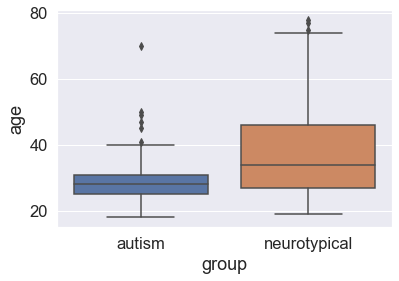

In [20]:
#dems.age = dems.age.astype(int)
#f, ax = plt.subplots(1, 2, figsize=(8,5))
#sns.histplot(x='age',  dat=dems.loc[dems.group == 'control'], ax=ax[0])
#sns.displot(x='age',  dat=dems.loc[dems.group == 'autism'])
#dems['age'] = dems.age.astype(int)
g = sns.boxplot(data=dems, y="age", x='group');
#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
plt.savefig('./Figures/groups_age.png', dpi=300.0)

In [15]:
import pingouin as pg
import scipy.stats as stats

# Test if age is significantly difference between cohorts.
# First make sure equal variances of each group using levene's test
stats.levene(dems.loc[dems.group == 'neurotypical'].age, dems.loc[dems.group == 'autism'].age)

LeveneResult(statistic=105.1479882317878, pvalue=6.091805726706298e-23)

In [17]:
# we had to reject the null in the levene's test. which means we do not meet assumptions for a standard students T test and must instead used Welches T . .ttest in pingoiun can do this with the correction arg

pg.ttest(x=dems.loc[dems.group == 'neurotypical'].age, y=dems.loc[dems.group == 'autism'].age, correction=True)



,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,11.732427,606.914849,two-sided,8.596808e-29,"[7.54, 10.57]",0.808474,4.196e+25,1.0


Since the groups have difference ages, we want to test if the effect of group on RT is mediated by age.

In [36]:
# group -> age -> RT
df3['group_bool'] = [True if x == 'autism' else False  for x in df3.group]
df3['corrected_rt'] = df3.corrected_rt.astype(float)
df3['age'] = df3.age.astype(int)
df3['prolific_id'] = df3.prolific_id.astype(str)
#pg.mediation_analysis(data=df3, x='group_bool', y='corrected_rt', m='age')
#np.isfinite(df3.age.values)
df3.dtypes


prolific_id            object
group                  object
scenario              float64
correct               float64
corrected_rt          float64
id                      int64
age                     int64
gender                 object
ethnicity              object
education              object
diag                   object
autism_exp             object
session_id             object
participation_date     object
browser                object
browser_version        object
screen_width           object
screen_height          object
operating_sys          object
operating_sys_lang     object
GMT_timestamp          object
email                  object
recaptcha_complete    float64
block1_complete         int64
block2_complete         int64
block3_complete         int64
completion_code        object
completion_time        object
feedback               object
pid                    object
group_bool               bool
dtype: object

Let's make one big csv file for stats.

In [37]:
full.columns

Index(['prolific_id', 'scenario', 'belief_type', 'ascription_type', 'correct',
       'corrected_rt', 'group'],
      dtype='object')

In [ ]:
plt.figure(figsize=(10,7))
g = sns.boxplot(data=dems, y="age", hue='gender', x='group')
plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0);
plt.savefig('./Figures/groups_agexgend.png', dpi=300.0)

In [18]:
dd = full.groupby(['prolific_id', 'group']).mean()
dd = dd.reset_index().sort_values('prolific_id')
dems['pid'] = dems.prolific_id
dems = dems.sort_values('prolific_id')
dems = dems.reset_index(drop=True)
df3 = pd.concat([dd, dems], axis=1)
dat = dat.loc[:,~dat.columns.duplicated()].copy() # prolific id from both tables will be in df, remove duplicate
df3 = df3.loc[:, ~df3.columns.duplicated()].copy()

<ipython-input-18-bf8926d29b76>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dd = full.groupby(['prolific_id', 'group']).mean()


True


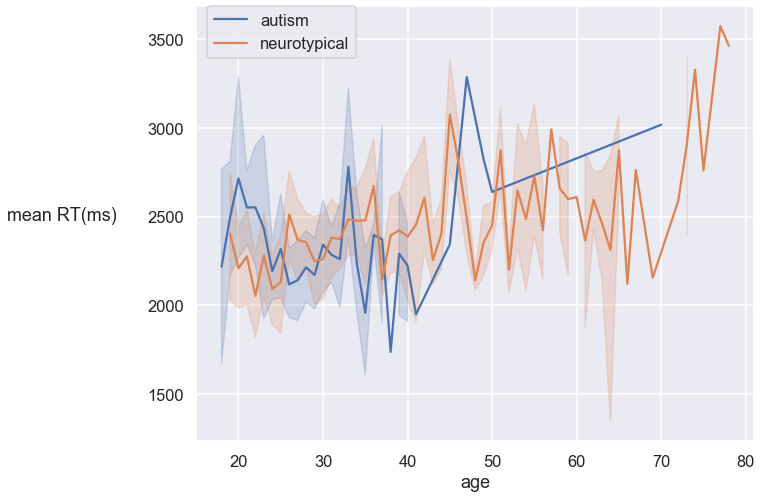

In [19]:
print(sum([df3.prolific_id.values[x] == df3.pid.values[x] for x in range(len(df3))]) == len(df3))
sns.set_context("talk")
#f, ax = plt.subplots(figsize=(10,8))
plt.figure(figsize=(10,8))
sns.lineplot(x='age', y='corrected_rt',hue='group', data=df3);
plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0);
plt.ylabel('mean RT(ms)', labelpad=85, rotation=0);
#g.axes.yaxis.labelpad = 50
#g.axes.yaxis.s
plt.savefig('./Figures/groups_agexrt.png', dpi=200);

In [ ]:
f, ax = plt.subplots(figsize=(10,8))
g = sns.lineplot(x='age', y='corrected_rt',hue='group', data=df3, ax=ax);
#xxg.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
g.yaxis.set_label_text('mean RT(ms)')

plt.savefig('./Figures/help.png', dpi=300)

In [ ]:
plt.figure(figsize=(10,7))
g = sns.boxplot(data=df3, x="gender", y='corrected_rt', hue='group')
plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0);
#plt.savefig('./Figures/groups_agexgend.png', dpi=300.0)

In [ ]:
dems.to_csv('../analysis/Data/dem_dat.csv', header=True)

# 10. Old Studies

In [53]:
e1adat = pd.read_csv('../OldSharedFiles/knowledgeBeforeBelief/data/study1a.csv', header=0)
e1adat['group'] = 'study 1A'
e1bdat = pd.read_csv('../OldSharedFiles/knowledgeBeforeBelief/data/study1b.csv', header=0)
e1bdat['group'] = 'study 1B'
e1dat = pd.concat([e1adat, e1bdat], ignore_index=True)

In [62]:
'''
condition: Distractor or Test
'''
#e1dat = pd.read_csv('../OldSharedFiles/knowledgeBeforeBelief/data/study1b.csv', header=0)
e1dat = e1dat.loc[e1dat.condition != 'D']
e1dat.sort_values('subj')
#sdat = e1dat.loc[e1dat.subj == e1dat.subj.unique()[10]]
e1dat['ascription_type'] = ['Thinks' if int(x) == 0 else 'Knows'  for x in e1dat.question]
for v, cond in zip(sorted(e1dat.condition.unique()),['True Info', 'False Info', 'Ignorance', 'True Info', 'False Info', 'Ignorance']):
    e1dat.loc[e1dat.condition == v, 'belief_type'] = cond

for v, cond in zip(sorted(e1dat.response.unique()), [False, True]):
    e1dat.loc[e1dat.response == v, 'resp'] = cond

e1dat['correct_answer'] = False
e1dat.loc[e1dat.belief_type == 'True Info', 'correct_answer'] = True
e1dat['correct'] = e1dat.apply(lambda row: row['resp'] == row['correct_answer'], axis=1)


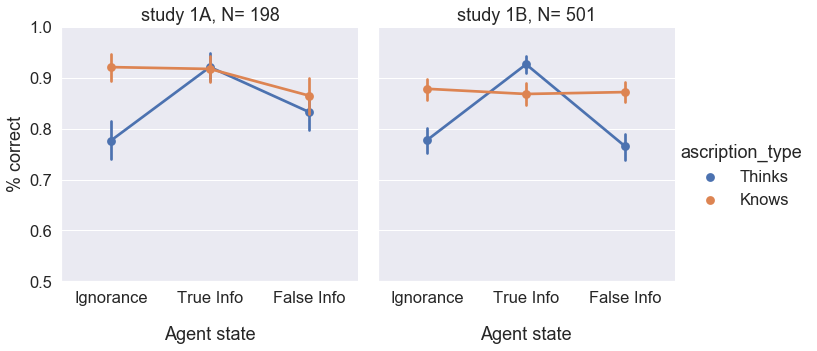

In [63]:
sns.set(font_scale=1.5)
g = sns.catplot(x='belief_type', order=['Ignorance', 'True Info', 'False Info'], y='correct', hue='ascription_type', hue_order=['Thinks', 'Knows'], col='group', kind='point', data=e1dat, aspect=1);
g.set(ylim=(.5, 1));
for aa in [0, 1]:
    g.axes[0][aa].yaxis.set_label_text("% correct")
    g.axes[0][aa].xaxis.set_label_text("Agent state")
    g.axes[0][aa].xaxis.labelpad = 20
    #g.axes[0][aa].legend_.remove()

g.axes[0][0].title.set_text(f'study 1A, N= {len(e1dat.loc[e1dat.group=="study 1A"].subj.unique())}')
g.axes[0][1].title.set_text(f'study 1B, N= {len(e1dat.loc[e1dat.group=="study 1B"].subj.unique())}')
plt.savefig('./Figures/acc_olds1.png')

In [ ]:
e1dat.correct_answer.iloc[0]

# STATISTICS (FML)

In [ ]:
import pymer4